In [23]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot
import scipy.integrate as scyint
import matplotlib.animation as animation
from JSAnimation.IPython_display import display_animation
import math
import itertools as itool

In [2]:
class BoundaryCondition:
    RBC, PBC = range(2)
    
class StartConf:
    Triangular, Rectangular, Random, Confined = range(4)

In [3]:
class particle2(object):

    def __init__(self, mass=1., x=0., y=0., vx=0., vy=0.):
        self.mass = mass
        self.x = x
        self.y = y
        self.vx = vx
        self.vy = vy
        self.fx = 0.
        self.fy = 0.
       
    def euler(self, fx, fy, dt):
        self.vx = self.vx + self.fx/self.mass*dt
        self.vy = self.vy + self.fy/self.mass*dt
        self.x = self.x + self.vx*dt
        self.y = self.y + self.vy*dt
        
    def accel(self, dt):
        self.vx = self.vx + self.fx/self.mass*dt
        self.vy = self.vy + self.fy/self.mass*dt
        
    def move(self, dt, dt2half):
        self.x = self.x + self.vx*dt + self.fx/self.mass*dt2half
        self.y = self.y + self.vy*dt + self.fy/self.mass*dt2half       
    

In [47]:
class MDsystem(object):

    def __init__(self, lx, ly, N, dt, bc): 
        self.N = N
        self.lx = ly
        self.ly = lx
        self.dt = dt
        self.dt2 = dt*dt
        self.dthalf = dt * 0.5
        self.dt2half = self.dt2 * 0.5
        self.bc = bc
        self.particles = [particle2()]
        for i in range(1,N):
            self.particles.append(particle2()) # we create a list of N particles

    def init(self, config, vmax):
        np.random.seed(1272121) # arbitrary seed
        nrows = int(math.sqrt(N)*float(self.ly)/float(self.lx))
        ncols = int(math.sqrt(N)*float(self.lx)/float(self.ly)) + 1
        ax = float(lx) / float(ncols);
        ay = float(ly) / float(nrows);
        i = 0;

        if config == StartConf.Triangular:
            for row, col in itool.product(range(nrows),range(ncols)):
                if i >= self.N: 
                    break
                self.particles[i].x = col*ax+ax/2.
                self.particles[i].y = row*ay+ay/2.
                i+=1

            for row, col in itool.product(range(1,nrows),range(1,ncols)):
                if i >= self.N: 
                    break
                self.particles[i].x = col*ax+ax/2.+ax/4.
                self.particles[i].y = row*ay+ay/2.+ay/4.
                i+=1
                
        elif config == StartConf.Rectangular:
            for row, col in itool.product(range(nrows),range(ncols)):
                if i >= self.N: 
                    break
                self.particles[i].x = col*ax+ax/2.
                self.particles[i].y = row*ay+ay/2.
                i+=1

            for row, col in itool.product(range(1,nrows),range(1,ncols)):
                if i >= self.N: 
                    break
                self.particles[i].x = col*ax+ax/2.+ax/4.
                self.particles[i].y = row*ay+ay/2.+ay/4.
                i+=1
                
        elif config == StartConf.Confined:
            ax /= 2.
            for row, col in itool.product(range(nrows),range(ncols)):
                if i >= self.N: 
                    break
                self.particles[i].x = col*ax+ax/2.
                self.particles[i].y = row*ay+ay/2.
                i+=1

            for row, col in itool.product(range(nrows),range(ncols)):
                if i >= self.N: 
                    break
                self.particles[i].x = col*ax+ax/2.+ax/4.
                self.particles[i].y = row*ay+ay/2.+ay/4.
                i+=1
                
        elif config == StartConf.Random:
            for i in range(self.N):
                overlap = True;
                while overlap:
                    overlap = False;
                    self.particles[i].x = np.random.random()*self.lx
                    self.particles[i].y = np.random.random()*self.ly
                    for j in range(i):
                        r12 = self.distance(self.particle[i], self.particle.p[j])
                        if r12 < 1.: 
                            overlap = True;
                            break
                                
        # Velocities
        for p in self.particles:
            p.vx = vmax*(2. * np.random.random() - 1);
            p.vy = vmax*(2. * np.random.random() - 1);

        # We set total momentum to zero
        vxcm = 0.
        vycm = 0. # Velocity of the center of mass
        for p in self.particles:
            vxcm += p.vx;
            vycm += p.vy;
        
        vxcm /= self.N
        vycm /= self.N
        for p in self.particles:
            p.vx -= vxcm;
            p.vy -= vycm;
            
        self.forces()          
        
    def evolve(self):
        for p in self.particles:
            p.move(self.dt, self.dt2half)
            p.accel(self.dthalf)
            self.boundary(p)

        self.forces()

        for p in self.particles:
            p.accel(self.dthalf)

        
    def distance(self, p, other):
        (r12, dx, dy) = self.distance2(p, other)
        return math.sqrt(r12)

    def distance2(self, p, other):
        dx = other.x - p.x;
        dy = other.y - p.y;


        # nearest image convention
        if self.bc == BoundaryCondition.PBC:
            if abs(dx) > self.lx/2:
                dx -= dx*lx/abs(dx)
                
            if abs(dy) > self.ly/2:
                dy -= dy*ly/abs(dy)
        
        r12 = dx * dx + dy * dy
        return (r12, dx, dy)

    def force(self, p, other):  #Lennard-Jones
        (r12,dx,dy) = self.distance2(p, other)
        r2 = 1./r12
        r6 = r2 * r2 * r2
        f = 24.*r2*r6*(2.*r6-1.)
        fx = f*(-dx)
        fy = f*(-dy)
        return (fx, fy);
        
      
    def forces(self):
        # Compute the interaction forces between particles
        for p in self.particles:
            p.fx = 0.
            p.fy = 0.
    
        for i in range(self.N):
            p = self.particles[i]
            for j in range(i+1,self.N):
                other = self.particles[j]
                (fx, fy) = self.force(p, other)
                p.fx += fx
                p.fy += fy
                other.fx -= fx
                other.fy -= fy

    def boundary(self, p):
        if self.bc == BoundaryCondition.RBC:
            
            if p.x < 0:  
                p.x = -p.x
                p.vx = -p.vx
            if p.y < 0:
                p.y = -p.y
                p.vy = -p.vy
            if p.x > self.lx:
                p.x = 2*self.lx - p.x
                p.vx = -p.vx
            if p.y > self.ly:
                p.y = 2*self.ly - p.y
                p.vy = -p.vy

        elif self.bc == BoundaryCondition.PBC:

            if p.x < 0: 
                p.x += lx
            elif p.x > lx:  
                p.x -= lx
            if p.y < 0:  
                p.y += ly
            elif p.y > ly:  
                p.y -= ly
#            c = (p.x+2*self.lx)/self.lx
#            p.x = p.x + 2*self.lx - int(c)*self.lx
#            c = (p.y+2*self.ly)/self.ly
#            p.y = p.y + 2*self.ly - int(c)*self.ly
            
    def kinetic_energy(self, m): # Challenge
        ke = np.zeros([1,self.N])
        for i in range(self.N):
            ke[0,i] = 0.5*m*np.sqrt(self.particles[i].vx**2+self.particles[i].vy**2)
        ke_av = np.mean(ke[0,:])
        return ke_av
    
    def pot_energy(self): # Challenge
        pe = np.zeros([1,self.N])
        for i in range(self.N):
            for j in range(self.N):
                if j == i:
                    continue
                (r12,dx,dy) = self.distance2(self.particles[i],self.particles[j])
                pe[0,i] += 4*((1/r12)**12 - (1/r12)**6)
        pe_av = np.mean(pe[0,:])
        return pe_av
    
    def total_energy(self):
        return self.kinetic_energy(m)+self.pot_energy()
    

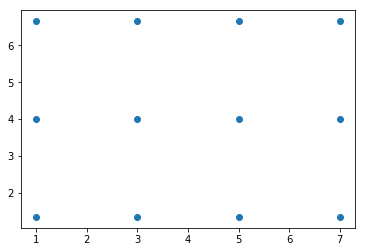

In [48]:
lx = 8
ly = 8
N = 12
dt = 0.02
v0 = 1

S = MDsystem(lx, ly, N, dt, BoundaryCondition.RBC)
S.init(StartConf.Rectangular, v0)

x = np.zeros([1,N])
y = np.zeros([1,N])
for i in range(0,N):
    x[0,i] = S.particles[i].x
    y[0,i] = S.particles[i].y

pyplot.scatter(x[0,:], y[0,:])

In [49]:
S = MDsystem(lx, ly, N, dt, BoundaryCondition.RBC)
T = [1,2,4]
nsteps = 100
ntrials = 10
m = 1

T_av = np.zeros([len(T), ntrials])
K_av = np.zeros([len(T), ntrials*nsteps])
U_av = np.zeros([len(T), ntrials*nsteps])
E_tot = np.zeros([len(T), ntrials*nsteps])

for i in range(len(T)):
    S.init(StartConf.Rectangular, np.sqrt(2*T[i]))
    for j in range(ntrials):
        v_av = np.zeros([1,nsteps])
        for k in range(nsteps):
            av_track = int(k+nsteps*j)
            K_av[i,int(k+nsteps*j)] = S.kinetic_energy(m)
            U_av[i,int(k+nsteps*j)] = S.pot_energy()
            E_tot[i,int(k+nsteps*j)] = S.total_energy()
            for p in S.particles:
                v_av[0,k] += (p.vx**2 + p.vy**2)/N
            S.evolve()
        T_av[i,j] = np.mean(v_av[0,:])/2
        for p in S.particles:
            p.vx *= np.sqrt(T[i]/T_av[i,j])
            p.vy *= np.sqrt(T[i]/T_av[i,j])

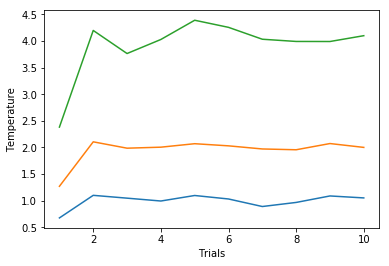

In [50]:
n = np.linspace(1,ntrials,ntrials)
for i in range(0,3):
    pyplot.plot(n,T_av[i,:])
pyplot.xlabel('Trials')
pyplot.ylabel('Temperature')

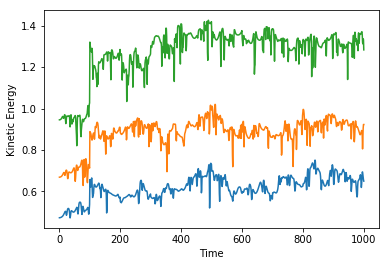

In [51]:
n = np.linspace(1,ntrials*nsteps, ntrials*nsteps)
for i in range(0,3):
    pyplot.plot(n,K_av[i,:])
pyplot.xlabel('Time')
pyplot.ylabel('Kinetic Energy')

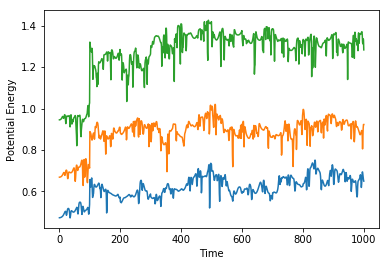

In [52]:
n = np.linspace(1,ntrials*nsteps, ntrials*nsteps)
for i in range(0,3):
    pyplot.plot(n,K_av[i,:])
pyplot.xlabel('Time')
pyplot.ylabel('Potential Energy')

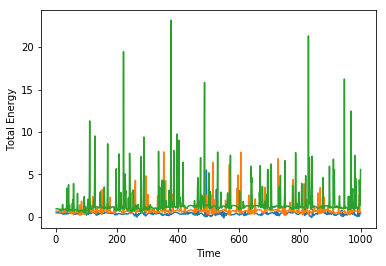

In [54]:
n = np.linspace(1,ntrials*nsteps, ntrials*nsteps)
for i in range(0,3):
    pyplot.plot(n,E_tot[i,:])
pyplot.xlabel('Time')
pyplot.ylabel('Total Energy')